In [93]:
import pandas as pd

# Universe of stocks
universe = ['IBM', 'MSFT', 'GOOG', 'AAPL', 'AMZN', 'META', 'NFLX', 'TSLA', 'ORCL', 'SAP']

# Dictionary to store dataframes for each stock
stock_data = {}

# Load the data for each stock
for stock in universe:
    stock_data[stock] = pd.read_csv(f'/content/{stock.lower()}.csv')  # Replace with actual path to your CSV files

date_dataset = stock_data['IBM']['Date'].iloc[::-1].reset_index(drop=True)
# Example: Check the first few rows of the IBM data
print(stock_data['IBM'])


          Date    Open    High     Low   Close  Adj Close      Volume
0    28-Dec-18  109.20  109.75  107.55  108.06      82.36   5,352,905
1    27-Dec-18  105.15  108.78  104.66  108.78      82.91   6,323,698
2    26-Dec-18  103.25  106.49  101.28  106.49      81.16   6,951,507
3    24-Dec-18  105.07  106.12  102.77  102.84      78.38   3,997,184
4    21-Dec-18  107.55  110.21  105.58  106.06      80.84  10,864,279
..         ...     ...     ...     ...     ...        ...         ...
245   8-Jan-18  155.51  156.70  154.59  156.28     113.96   5,478,425
246   5-Jan-18  155.30  155.74  154.02  155.34     113.27   5,434,807
247   4-Jan-18  152.63  155.18  152.36  154.59     112.72   7,903,785
248   3-Jan-18  150.42  152.78  149.46  151.52     110.49   9,875,914
249   2-Jan-18  147.71  148.00  146.79  147.47     107.53   4,395,815

[250 rows x 7 columns]


In [94]:
# Dividend Calculation
def calculate_dividends(df):
    df['Close_Ratio'] = df['Close'].shift(1) / df['Close']
    df['Adj_Close_Ratio'] = df['Adj Close'].shift(1) / df['Adj Close']
    df['Dividend_Diff'] = df['Close_Ratio'] - df['Adj_Close_Ratio']
    df['Dividend'] = df['Dividend_Diff'] * df['Close']
    df['Dividend'] = df['Dividend'].round(2)
    # Replace negative values in the 'Dividend' column with 0
    df['Dividend'] = df['Dividend'].apply(lambda x: max(x, 0))
    return df[['Dividend']]

dividend_df=pd.DataFrame()
for stock in universe:
    df = stock_data[stock]
    df= df.iloc[::-1].reset_index(drop=True)
    dividends = calculate_dividends(df)
    # print(dividends.head(60))
    dividend_df[stock] = dividends
# print(dividend_df)

In [95]:
# Create a combined DataFrame for 'Close' and 'Adj Close' prices
close_adjclose_df = pd.DataFrame()

# Add the 'Close' and 'Adj Close' columns for each stock
for stock, data in stock_data.items():
    close_adjclose_df[f'{stock}_Close'] = data['Close']
    close_adjclose_df[f'{stock}_Adj Close'] = data['Adj Close']


close_adjclose_df = close_adjclose_df.iloc[::-1].reset_index(drop=True)
# Preview the combined DataFrame
print(close_adjclose_df)


     IBM_Close  IBM_Adj Close  MSFT_Close  MSFT_Adj Close  GOOG_Close  \
0       147.47         107.53       85.95           79.79       53.25   
1       151.52         110.49       86.35           80.16       54.12   
2       154.59         112.72       87.11           80.87       54.32   
3       155.34         113.27       88.19           81.87       55.11   
4       156.28         113.96       88.28           81.96       55.35   
..         ...            ...         ...             ...         ...   
245     106.06          80.84       98.23           92.77       48.98   
246     102.84          78.38       94.13           88.90       48.81   
247     106.49          81.16      100.56           94.97       51.97   
248     108.78          82.91      101.18           95.56       52.19   
249     108.06          82.36      100.39           94.81       51.85   

     GOOG_Adj Close  AAPL_Close  AAPL_Adj Close  AMZN_Close  AMZN_Adj Close  \
0             53.12       43.06           40

In [96]:
#1
# Starting portfolio on Jan 02, 2018
initial_fund = 5000000
stock_allocation = initial_fund / 5

# Get the closing prices for the 5 selected stocks on Jan 02, 2018
selected_stocks = ['IBM', 'MSFT', 'GOOG', 'AAPL', 'AMZN']
initial_prices = close_adjclose_df.loc[0, [f'{stock}_Close' for stock in selected_stocks]]
print(initial_prices)

# Calculate how many shares you can buy for each stock
shares = {stock: stock_allocation // initial_prices[f'{stock}_Close'] for stock in selected_stocks}

# Calculate the remaining cash after purchasing the stocks
cash = initial_fund - sum(shares[stock] * initial_prices[f'{stock}_Close'] for stock in shares)

# Print initial portfolio details
print(f"Shares bought: {shares}")
print(f"Remaining cash: ${cash}")

mtm = cash + sum(shares[stock] * close_adjclose_df.loc[0, f'{stock}_Close'] for stock in shares)
print(f"MTM on Jan 02, 2018: ${mtm}")


IBM_Close     147.47
MSFT_Close     85.95
GOOG_Close     53.25
AAPL_Close     43.06
AMZN_Close     59.45
Name: 0, dtype: float64
Shares bought: {'IBM': 6781.0, 'MSFT': 11634.0, 'GOOG': 18779.0, 'AAPL': 23223.0, 'AMZN': 16820.0}
Remaining cash: $150.5
MTM on Jan 02, 2018: $5000000.0


In [97]:

#2
# Function to rebalance portfolio every 5 days (buy low)
def rebalance_portfolio_low(start_day, df, shares, cash, days):
    """
    This function rebalances the portfolio every 5 days by selling all current holdings
    and buying the 5 stocks that dropped the most in 'Adj Close' price from the start day.
    """

    # Step 1: Calculate the percentage change in 'Adj Close' over 5 days (from start_day to start_day + 5)
    adj_close_changes = df.loc[start_day+days, [f'{stock}_Adj Close' for stock in universe]] / df.loc[start_day, [f'{stock}_Adj Close' for stock in universe]] - 1

    # Step 2: Find the 5 stocks that dropped the most in 'Adj Close' prices
    worst_performers = adj_close_changes.nsmallest(5)
    # print("\nWorst performers for rebalancing:")
    # print(worst_performers)

    # Step 3: Sell all current shares and add the cash back
    for stock in shares:
        stock_symbol = stock  # Use stock symbol directly
        if shares[stock_symbol] > 0:
            # Sell at close price on start_day + 5 (i.e., Jan 09)
            cash += shares[stock_symbol] * df.loc[start_day+days, f'{stock_symbol}_Close']
        shares[stock_symbol] = 0  # Reset shares to 0 after selling

    # print(f"\nCash after selling all shares: ${cash}")

    # Step 4: Reallocate the cash into the 5 worst-performing stocks
    allocation_per_stock = cash / 5
    # print(f"Allocating ${allocation_per_stock} to each of the 5 worst-performing stocks.")

    for stock in worst_performers.index:
        stock_symbol = stock.split('_')[0]  # Get stock symbol (e.g., 'TSLA' from 'TSLA_Adj Close')
        shares_to_buy = allocation_per_stock // df.loc[start_day+days, f'{stock_symbol}_Close']  # Buy integer shares
        if shares_to_buy > 0:
            shares[stock_symbol] = shares_to_buy
            cash_spent = shares_to_buy * df.loc[start_day+days, f'{stock_symbol}_Close']
            cash -= cash_spent  # Subtract the cost of the shares from cash
            # print(f"Bought {shares_to_buy} shares of {stock_symbol} for ${cash_spent}")

    # print(f"\nCash remaining after buying shares: ${cash}")
    return shares, cash







In [98]:


# Function to rebalance portfolio every 5 days (buy low)
def rebalance_portfolio_high(start_day, df, shares, cash, days):
    """
    This function rebalances the portfolio every 5 days by selling all current holdings
    and buying the 5 stocks that surge the most in 'Adj Close' price from the start day.
    """

    # Step 1: Calculate the percentage change in 'Adj Close' over 5 days (from start_day to start_day + 5)
    adj_close_changes = df.loc[start_day+days, [f'{stock}_Adj Close' for stock in universe]] / df.loc[start_day, [f'{stock}_Adj Close' for stock in universe]] - 1

    # Step 2: Find the 5 stocks that surge the most in 'Adj Close' prices
    worst_performers = adj_close_changes.nlargest(5)

    # Step 3: Sell all current shares and add the cash back
    for stock in shares:
        stock_symbol = stock  # Use stock symbol directly
        if shares[stock_symbol] > 0:
            # Sell at close price on start_day + 5 (i.e., Jan 09)
            cash += shares[stock_symbol] * df.loc[start_day+days, f'{stock_symbol}_Close']
        shares[stock_symbol] = 0  # Reset shares to 0 after selling

    # print(f"\nCash after selling all shares: ${cash}")

    # Step 4: Reallocate the cash into the 5
    allocation_per_stock = cash / 5


    for stock in worst_performers.index:
        stock_symbol = stock.split('_')[0]  # Get stock symbol (e.g., 'TSLA' from 'TSLA_Adj Close')
        shares_to_buy = allocation_per_stock // df.loc[start_day+days, f'{stock_symbol}_Close']  # Buy integer shares
        if shares_to_buy > 0:
            shares[stock_symbol] = shares_to_buy
            cash_spent = shares_to_buy * df.loc[start_day+days, f'{stock_symbol}_Close']
            cash -= cash_spent  # Subtract the cost of the shares from cash
            # print(f"Bought {shares_to_buy} shares of {stock_symbol} for ${cash_spent}")

    # print(f"\nCash remaining after buying shares: ${cash}")
    return shares, cash



In [99]:
def calculate_mtm(df, current_day, shares, cash):
    # Calculate the total value of stocks held by summing up the value of each stock (shares * Close price)
    stock_values = sum(shares[stock] * df.loc[current_day, f'{stock}_Close'] for stock in shares)

    # The MTM value is the sum of the value of all stocks held and the cash
    mtm = cash + stock_values

    return mtm

In [100]:
def apply_dividends(dividend_df, current_day, shares):
    total_dividends = 0.0  # Initialize total dividends

    # Loop through each stock in the shares dictionary
    for stock, num_shares in shares.items():
        # Check if the stock has a dividend for the current day
        dividend_value = dividend_df.loc[current_day, stock]

        # If dividend value is not NaN (i.e., a valid dividend is issued)
        if not pd.isna(dividend_value):
            # Calculate the dividend payout for the stock (shares * dividend value)
            dividend_payout = num_shares * dividend_value

            # Add this stock's dividend payout to the total dividends
            total_dividends += dividend_payout
    # print(total_dividends)

    return total_dividends



In [101]:
# List to store daily MTM values
daily_mtm_strategy_5_days_rebalancing_of_buying_low= [5000000]
shares_low = shares.copy()
cash_low = cash
for i in range(1, 250):
  # print(i)
  cash_low = cash_low + apply_dividends(dividend_df, i, shares_low)
  if i%5 == 0 and i<245:
    shares_low, cash_low = rebalance_portfolio_low(i, close_adjclose_df, shares_low, cash_low, 5)
    # print(shares_low, cash_low)
  # Calculate MTM for the current day
  mtm_value = calculate_mtm(close_adjclose_df, i, shares_low, cash_low)
  # print(mtm_value)
  daily_mtm_strategy_5_days_rebalancing_of_buying_low.append(mtm_value)
print("MTM on 31-Dec-2018 for % days rebalancing of buying low: ", daily_mtm_strategy_5_days_rebalancing_of_buying_low[-1])

MTM on 31-Dec-2018 for % days rebalancing of buying low:  5484522.659999999


In [102]:
# List to store daily MTM values
daily_mtm_strategy_5_days_rebalancing_of_buying_high= [5000000]
shares_high = shares.copy()
cash_high = cash
for i in range(1, 250):
  # print(i)
  cash_high = cash_high + apply_dividends(dividend_df, i, shares_high)
  if i%5 == 0 and i<245:
    shares_high, cash_high = rebalance_portfolio_high(i, close_adjclose_df, shares_high, cash_high, 5)
    # print(shares_high, cash_high)
  # Calculate MTM for the current day
  mtm_value = calculate_mtm(close_adjclose_df, i, shares_high, cash_high)
  # print(mtm_value)
  daily_mtm_strategy_5_days_rebalancing_of_buying_high.append(mtm_value)
print("MTM on 31-Dec-2018 for % days rebalancing of buying high : ",daily_mtm_strategy_5_days_rebalancing_of_buying_high[-1])

MTM on 31-Dec-2018 for % days rebalancing of buying high :  4836909.010000003


In [103]:
mtm_df = pd.DataFrame()
mtm_df['Date'] = date_dataset
mtm_df['daily_mtm_strategy_5_days_rebalancing_of_buying_low']= daily_mtm_strategy_5_days_rebalancing_of_buying_low
mtm_df['daily_mtm_strategy_5_days_rebalancing_of_buying_high']= daily_mtm_strategy_5_days_rebalancing_of_buying_high


close_prices = close_adjclose_df[[f'{stock}_Close' for stock in universe]]
high_tech_index = close_prices.mean(axis=1)

mtm_df['high_tech_index'] = high_tech_index



mtm_df

,Date,daily_mtm_strategy_5_days_rebalancing_of_buying_low,daily_mtm_strategy_5_days_rebalancing_of_buying_high,high_tech_index
0,2-Jan-18,5000000.00,5000000.00,95.206
1,3-Jan-18,5061305.39,5061305.39,96.715
2,4-Jan-18,5103906.70,5103906.70,97.392
3,5-Jan-18,5164255.45,5164255.45,98.660
4,8-Jan-18,5187453.68,5187453.68,99.238
...,...,...,...,...
245,21-Dec-18,5214240.32,4695352.38,89.262
246,24-Dec-18,5022090.84,4585310.38,86.501
247,26-Dec-18,5457981.70,4813716.81,92.441
248,27-Dec-18,5422692.58,4858288.53,92.940


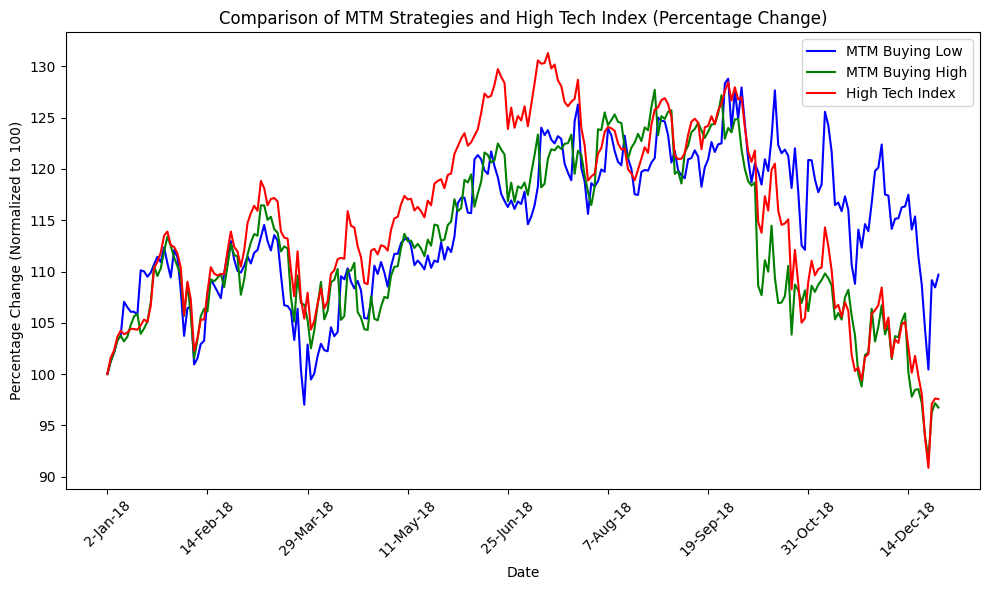

In [104]:
import matplotlib.pyplot as plt

mtm_df['mtm_low_pct_change'] = (mtm_df['daily_mtm_strategy_5_days_rebalancing_of_buying_low'] / mtm_df['daily_mtm_strategy_5_days_rebalancing_of_buying_low'][0]) * 100
mtm_df['mtm_high_pct_change'] = (mtm_df['daily_mtm_strategy_5_days_rebalancing_of_buying_high'] / mtm_df['daily_mtm_strategy_5_days_rebalancing_of_buying_high'][0]) * 100
mtm_df['high_tech_index_pct_change'] = (mtm_df['high_tech_index'] / mtm_df['high_tech_index'][0]) * 100

plt.figure(figsize=(10, 6))

plt.plot(mtm_df['Date'], mtm_df['mtm_low_pct_change'], label='MTM Buying Low', color='blue')
plt.plot(mtm_df['Date'], mtm_df['mtm_high_pct_change'], label='MTM Buying High', color='green')
plt.plot(mtm_df['Date'], mtm_df['high_tech_index_pct_change'], label='High Tech Index', color='red')

plt.title('Comparison of MTM Strategies and High Tech Index (Percentage Change)')
plt.xlabel('Date')
plt.ylabel('Percentage Change (Normalized to 100)')

x_ticks = range(0, len(mtm_df['Date']), 30)
plt.xticks(x_ticks, mtm_df['Date'][x_ticks], rotation=45)

plt.legend()
plt.tight_layout()
plt.show()


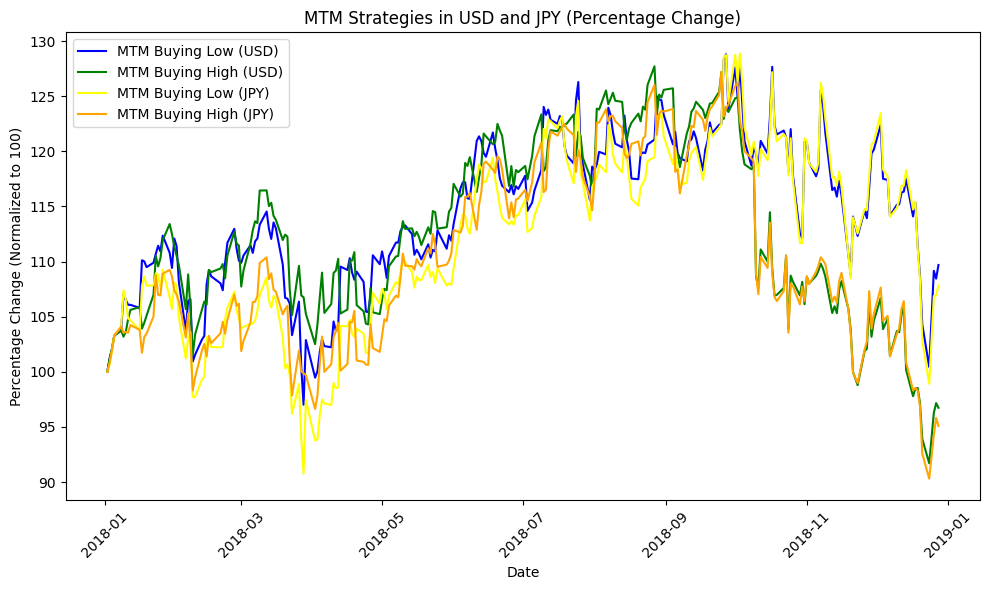

In [108]:
usd_jpy_df = pd.read_csv('/content/usdjpy.csv', encoding='ISO-8859-1')
usd_jpy_df.rename(columns={'Closeÿ': 'Close'}, inplace=True)

mtm_df['Date'] = pd.to_datetime(mtm_df['Date'])
# usd_jpy_df['Date'] = pd.to_datetime(usd_jpy_df['Date'])
usd_jpy_df['Date'] = pd.to_datetime(usd_jpy_df['Date'], format='%d-%b-%y')

merged_df = pd.merge(mtm_df, usd_jpy_df[['Date', 'Close']], on='Date', how='inner')

merged_df['mtm_low_jpy'] = merged_df['daily_mtm_strategy_5_days_rebalancing_of_buying_low'] * merged_df['Close']
merged_df['mtm_high_jpy'] = merged_df['daily_mtm_strategy_5_days_rebalancing_of_buying_high'] * merged_df['Close']

merged_df['mtm_low_pct_change_usd'] = (merged_df['daily_mtm_strategy_5_days_rebalancing_of_buying_low'] / merged_df['daily_mtm_strategy_5_days_rebalancing_of_buying_low'][0]) * 100
merged_df['mtm_high_pct_change_usd'] = (merged_df['daily_mtm_strategy_5_days_rebalancing_of_buying_high'] / merged_df['daily_mtm_strategy_5_days_rebalancing_of_buying_high'][0]) * 100

merged_df['mtm_low_pct_change_jpy'] = (merged_df['mtm_low_jpy'] / merged_df['mtm_low_jpy'][0]) * 100
merged_df['mtm_high_pct_change_jpy'] = (merged_df['mtm_high_jpy'] / merged_df['mtm_high_jpy'][0]) * 100

plt.figure(figsize=(10, 6))

plt.plot(merged_df['Date'], merged_df['mtm_low_pct_change_usd'], label='MTM Buying Low (USD)', color='blue')
plt.plot(merged_df['Date'], merged_df['mtm_high_pct_change_usd'], label='MTM Buying High (USD)', color='green')

plt.plot(merged_df['Date'], merged_df['mtm_low_pct_change_jpy'], label='MTM Buying Low (JPY)', color='yellow')
plt.plot(merged_df['Date'], merged_df['mtm_high_pct_change_jpy'], label='MTM Buying High (JPY)', color='orange')

plt.title('MTM Strategies in USD and JPY (Percentage Change)')
plt.xlabel('Date')
plt.ylabel('Percentage Change (Normalized to 100)')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()


In [106]:
merged_df

,Date,daily_mtm_strategy_5_days_rebalancing_of_buying_low,daily_mtm_strategy_5_days_rebalancing_of_buying_high,high_tech_index,mtm_low_pct_change,mtm_high_pct_change,high_tech_index_pct_change,Close,mtm_low_jpy,mtm_high_jpy,mtm_low_pct_change_usd,mtm_high_pct_change_usd,mtm_low_pct_change_jpy,mtm_high_pct_change_jpy
0,2018-01-02,5000000.00,5000000.00,95.206,100.000000,100.000000,100.000000,112.770,5.638500e+08,5.638500e+08,100.000000,100.000000,100.000000,100.000000
1,2018-01-03,5061305.39,5061305.39,96.715,101.226108,101.226108,101.584984,112.244,5.681012e+08,5.681012e+08,101.226108,101.226108,100.753953,100.753953
2,2018-01-04,5103906.70,5103906.70,97.392,102.078134,102.078134,102.296074,112.607,5.747356e+08,5.747356e+08,102.078134,102.078134,101.930588,101.930588
3,2018-01-05,5164255.45,5164255.45,98.660,103.285109,103.285109,103.627923,112.783,5.824402e+08,5.824402e+08,103.285109,103.285109,103.297016,103.297016
4,2018-01-08,5187453.68,5187453.68,99.238,103.749074,103.749074,104.235027,113.154,5.869811e+08,5.869811e+08,103.749074,103.749074,104.102356,104.102356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,2018-12-21,5214240.32,4695352.38,89.262,104.284806,93.907048,93.756696,111.171,5.796723e+08,5.219870e+08,104.284806,93.907048,102.806121,92.575511
246,2018-12-24,5022090.84,4585310.38,86.501,100.441817,91.706208,90.856669,111.054,5.577233e+08,5.092171e+08,100.441817,91.706208,98.913412,90.310731
247,2018-12-26,5457981.70,4813716.81,92.441,109.159634,96.274336,97.095771,110.402,6.025721e+08,5.314440e+08,109.159634,96.274336,106.867446,94.252720
248,2018-12-27,5422692.58,4858288.53,92.940,108.453852,97.165771,97.619898,111.206,6.030360e+08,5.402708e+08,108.453852,97.165771,106.949712,95.818185


In [107]:
# Initialize variables to store the optimal interval and MTM values
best_days_low = None
best_mtm_low = -float('inf')

best_days_high = None
best_mtm_high = -float('inf')

# Try different days intervals (e.g., 1 to 50 days)
for days in range(1, 51):
    # print(f"Testing rebalancing interval: {days} days")

    # Low strategy
    shares_low = shares.copy()
    cash_low = cash
    for i in range(1, 250):
        cash_low = cash_low + apply_dividends(dividend_df, i, shares_low)
        if i % days == 0 and i < (250 - days):
            shares_low, cash_low = rebalance_portfolio_low(i, close_adjclose_df, shares_low, cash_low, days)
        mtm_value_low = calculate_mtm(close_adjclose_df, i, shares_low, cash_low)

    # Store the result if it maximizes MTM on 31-Dec-2018
    if mtm_value_low > best_mtm_low:
        best_mtm_low = mtm_value_low
        best_days_low = days

    # High strategy
    shares_high = shares.copy()
    cash_high = cash
    for i in range(1, 250):
        cash_high = cash_high + apply_dividends(dividend_df, i, shares_high)
        if i % days == 0 and i < (250 - days):
            shares_high, cash_high = rebalance_portfolio_high(i, close_adjclose_df, shares_high, cash_high, days)
        mtm_value_high = calculate_mtm(close_adjclose_df, i, shares_high, cash_high)

    # Store the result if it maximizes MTM on 31-Dec-2018
    if mtm_value_high > best_mtm_high:
        best_mtm_high = mtm_value_high
        best_days_high = days

# Print the best rebalancing interval and the corresponding MTM for both strategies
print(f"Optimal rebalancing interval for buying low: {best_days_low} days, MTM on 31-Dec-2018: {best_mtm_low}")
print(f"Optimal rebalancing interval for buying high: {best_days_high} days, MTM on 31-Dec-2018: {best_mtm_high}")


Optimal rebalancing interval for buying low: 8 days, MTM on 31-Dec-2018: 5939382.229999998
Optimal rebalancing interval for buying high: 29 days, MTM on 31-Dec-2018: 5464221.960000002
